# Project 2: Digit Classification Naive Bayes

**Solution**

# Intro
---
In this project, you'll continue working on your own image recognition system for classifying digits. Read through the code and the instructions carefully and add your own code where indicated. Each problem can be addressed succinctly with the included packages -- please don't add any more. 
As always, you're welcome to work on the project in groups and discuss ideas over Slack, but <b> please prepare your own write-up (with your own code). </b>


## Grading
---
 - Make sure to answer every part in every question.
 - There are 6 questions, each equally weighted and an additional bonus question.
 - The extra credit question will be graded based on your attempts at feature engineering and resulting improved accuracy.
 - Read carefully what is asked including the notes.
 - Additional points may be deducted if:
   - the code is not clean, well commented,
  -  if the functions or answers are too long.

## Requirements:
---
1. Comment your code.
1. All graphs should have titles, label for each axis, and if needed a legend. It should be understandable on its own.
1. All code must run on colab.research.google.com
1. You should not import any additional libraries.
1. Try and minimize the use of the global namespace (meaning keep things in functions).

## Additional Reading and notes
---
If you're interested, check out these links related to digit recognition:

* Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/
* Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

Finally, if you'd like to get started with Tensorflow, you can read through this tutorial: https://www.tensorflow.org/tutorials/keras/basic_classification. It uses a dataset called "fashion_mnist", which is identical in structure to the original digit mnist, but uses images of clothing rather than images of digits. The number of training examples and number of labels is the same. In fact, you can simply replace the code that loads "fashion_mnist" with "mnist" and everything should work fine.

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

In [2]:
import sklearn
sklearn.__version__

'1.0.2'

Load the data. Notice that the data gets partitioned into training, development, and test sets. Also, a small subset of the training data called mini_train_data and mini_train_labels gets defined, which you should use in all the experiments below, unless otherwise noted.

In [3]:
# Load the digit data from https://www.openml.org/d/554 or from default local location '~/scikit_learn_data/...'
X, Y = fetch_openml(name='mnist_784', return_X_y=True, as_frame=False, cache=False)

# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print('data shape: ', X.shape)
print('label shape:', Y.shape)

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

data shape:  (70000, 784)
label shape: (70000,)


### Question 1: Applying a smoothing using numpy.
---

A common image processing technique is to smooth an image by **blurring**. The idea is that the value of a particular pixel is estimated as the weighted combination of the original value and the values around it. Typically, the blurring is Gaussian, i.e., the weight of a pixel's influence is determined by a Gaussian function over the distance to the relevant pixel.

1. Implement a simplified Gaussian blur filter by just using the 8 neighboring pixels like this: the smoothed value of a pixel is a weighted combination of the original value and the 8 neighboring values.
1. Choose some weights as a starting point. Produce and evaluate four 1-Nearest Neighbor models by applying your blur filter in these ways:
  1. Do not use the filter
  1. Filter the training data but not the dev data
  1. Filter the dev data but not the training data
  1. Filter both training data and dev data
1. Show the accuracies of the four models evaluated as described. What do you see? Can you explain why this is?
1. Experiment with weights that makes one model's accuracy at least 0.9.

Notes:
* Train on the (filtered) mini train set.
* Evaluate performance on the (filtered) dev set.
* A good trick to simplify your code is to use numpy's pad function to add 0s around your original array so you don't have to deal with "edge cases".
* In addition, you can use numpy to multiply and sum slices of two arrays.
* [This notebook](https://colab.research.google.com/drive/1eJXTQLtREXQjQIsLOA9uCrBl6B049-pO) might help shows some example numpy code.
* In general, [numpy operations will be much faster than for loops](https://colab.research.google.com/drive/1KJI4JtuIqVdyZHTTe_mAlKYA5XdLFp3_). 
* There are other Guassian blur filters available, for example in `scipy.ndimage.filters`. You are welcome to experiment with those, but in this question, please implement your own.

In [84]:
def Q1():
    
### STUDENT START ###
    #define function that accepts a one dimensional array and resizes as a square
    def sf(x):
        #derive the dimensions for a square array
        y = np.int16(np.sqrt(x.shape[0]))
        #reshape the array into a square
        x = x.reshape(y,y)
        #pad the array with zeros 
        x = np.pad(x, (1,1), 'constant', constant_values = (0,))
        #create a temp zero array of the same size as the original array
        temp = np.zeros((y,y))
        #generate average weight filter
        w = .8
        f = np.array([[1*w,1*w,1*w],[1*w,1,1*w],[1*w,1*w,1*w]])
        #for all elements in the matrix
        for i in range(1,y+1):
            for j in range(1,y+1):
                #apply the filter element-wise, take the average across the 3x3 grid
                #assign the average value to corresponding elements in temp
                temp[i-1,j-1] = np.average(f*x[i-1:i+2,j-1:j+2])
        temp = temp.reshape(y**2)
        return temp
    
    #unfiltered accuracy 
    #build and train classifier
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(mini_train_data,mini_train_labels)
    #predict on dev_data
    pred = knn.predict(dev_data)
    #print accuracy
    print("Unfiltered: "+str(classification_report(dev_labels,pred,output_dict=True)["accuracy"]))
    
    #filtered training data
    #create a temp arrach for results
    temp_train = np.zeros(mini_train_data.shape)
    #apply that function to every element in the training data to generate square, padded matrices 
    temp_train = np.apply_along_axis(sf, 1, mini_train_data)
    knn.fit(temp_train, mini_train_labels)
    pred = knn.predict(dev_data)
    print("Filter Training: "+str(classification_report(dev_labels,pred,output_dict=True)["accuracy"]))

    #filtered dev data
    temp_dev = np.zeros(dev_data.shape)
    temp_dev = np.apply_along_axis(sf, 1, dev_data)
    knn.fit(mini_train_data, mini_train_labels)
    pred = knn.predict(temp_dev)
    print("Filtered Dev: "+str(classification_report(dev_labels,pred,output_dict=True)["accuracy"]))
    
    #Both filtered
    knn.fit(temp_train,mini_train_labels)
    pred = knn.predict(temp_dev)
    print("Both filtered: "+str(classification_report(dev_labels,pred,output_dict=True)["accuracy"]))
    
### STUDENT END ###

Q1()

Unfiltered: 0.884
Filter Training: 0.9
Filtered Dev: 0.818
Both filtered: 0.904


### My written response: 
The results are what I expect to see as blurring in the training data makes the model more generalizable to the dev data; however, blurring the dev data and not the training data makes the model worse overall. 

### Question 2: Modeling your data and experimenting with different Naive Bayes models. 
---

1. Produce two Naive Bayes models and evaluate their performances.  Recall that Naive Bayes estimates P(feature|label), where each label is a categorical, not a real number.
  1. For the first model, map pixel values to either 0 or 1, representing white or black - you should pre-process the data or use `BernoulliNB`'s `binarize` parameter to set the white/black separation threshold to 0.1.  Use `BernoulliNB` to produce the model.
  1. For the second model, map pixel values to either 0, 1, or 2, representing white, gray, or black - you should pre-process the data, seting the white/gray/black separation thresholds to 0.1 and 0.9.  Here you'll likely need to implement a `trianarize` helper function. Since we are going beyond the binary representation of our features, you should use `MultinomialNB` to produce the model.
1. Show the Bernoulli model accuracy and the Multinomial model accuracy.
1. Does the multinomial version improve the results? Why or why not?

Notes:
* Train on the mini train set.
* Evaluate performance on the dev set.



In [22]:
# Solution with binarization by explicit binarize function

def Q2():

### STUDENT START ###
    #build NB calssifier with binarize at threshold of .1
    NB_class = BernoulliNB(binarize=.1)
    #fit the model
    NB_class.fit(mini_train_data, mini_train_labels)
    #score the model and print results
    print("Bernouli Accuracy: " +  
          str(NB_class.score(dev_data,dev_labels)))
    
    #helper function
    def trianarize(arr):
        
        #define int function to apply to each element in the input array
        def int_func(y):
            #for pixels between .1 and .9, assign 1
            if y > .1 and y <= .9:
                return 1
            #pixels greater than .9 assign 2
            elif y > .9:
                return 2
            #pixels less than .1 assign 0
            else:
                return 0
        
        #vectorize function for application along a vector 
        int_func_v = np.vectorize(int_func)
        
        #return modified array using our vectorized int function
        return int_func_v(arr)
        
    #pre-process data
    temp_mini = np.apply_along_axis(trianarize, 1, mini_train_data)
    temp_dev = np.apply_along_axis(trianarize, 1, dev_data)
    
    #train multinomial model
    MN_Class = MultinomialNB()
    MN_Class.fit(temp_mini, mini_train_labels)
    #print accuracy
    print("Multinomial accuracy: " + 
          str(MN_Class.score(temp_dev,dev_labels)))
    
### STUDENT END ###

Q2()

Bernouli Accuracy: 0.814
Multinomial accuracy: 0.807


### My Answer:
The multinonmial classifier does not appreciably improve the accuracy of the model as multiple categories do not add information when classifying a set of inputs. 

### Question 3: Applying the grid search technique.
1. Search across several values of the LaPlace smoothing parameter (alpha) to find its effect on a Bernoulli Naive Bayes model's performance.  Show the accuracy at each alpha value.
1. What is the best value for alpha? What is the accuracy when alpha is near 0? Is this what you'd expect?

Notes:
* Set binarization threshold to 0.
* Train on the mini train set.
* Evaluate performance by 5-fold cross-validation. 
* Use `GridSearchCV(..., ..., cv=..., scoring='accuracy', iid=False)` to vary alpha and evaluate performance by cross-validation.
* Cross-validation is based on partitions of the training data, so results will be a bit different than if you had used the dev set to evaluate performance.



In [31]:
def Q3(alphas):

### STUDENT START ###
    NB_GS = GridSearchCV(BernoulliNB(), alphas, 
                         scoring = "accuracy", cv = 5) #, iid = False)
    
    #now train model
    NB_GS.fit(mini_train_data, mini_train_labels)
    
    #show accuracty of all parameters
    print("Results (alpha - accuracy): \n")
    for i in range(len(alphas.get('alpha'))):
        print(str(alphas.get('alpha')[i]) + " - " +
              str(NB_GS.cv_results_['mean_test_score'][i]))
    
    #print best parameter
    print("\nBest Paramter: "+ str(NB_GS.best_params_))
    
    
### STUDENT END ###

alphas = {'alpha': [1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
Q3(alphas)


Results (alpha - accuracy): 

1e-10 - 0.8139999999999998
0.0001 - 0.819
0.001 - 0.825
0.01 - 0.8219999999999998
0.1 - 0.818
0.5 - 0.8130000000000001
1.0 - 0.8089999999999999
2.0 - 0.8049999999999999
10.0 - 0.783

Best Paramter: {'alpha': 0.001}


ANSWER: The best alpha parameter is .001. When alpha is 'near' zero the accuracy approaches that of the un-modified model, which is to be expected. 

### Question 4: Experimenting with Gaussian Naive Bayes
---
1. Produce a model using Guassian Naive Bayes, which is intended for real-valued features, and evaluate performance. You will notice that it does not work so well. 
1. Diagnose and explain the problem.
1. Apply a simple fix so that the model accuracy is around the same as for a Bernoulli Naive Bayes model. 
1. Show the model accuracy before your fix and the model accuracy after your fix.  
1. Explain your solution.

Notes:
* Train on the mini train set.
* Evaluate performance on the dev set.
* Take a look at var_smoothing argument for GaussianNB.
* Feel free to  examine theta and sigma to better understand what's happening. In general though, **it is not a good idea to mess with internal variables of the model**. These are stored in the model's `theta_` and `sigma_` attributes.

In [41]:
def Q4():

### STUDENT END ###
    
    #train GaussianNB model
    Gaus_NB = GaussianNB()
    Gaus_NB.fit(mini_train_data, mini_train_labels)
    
    #score Gaussian NB
    print("Initial Gaussian NB accuracy: " + 
          str(Gaus_NB.score(dev_data, dev_labels)))
    
    #use grid search to find values for smoothing that will yield 
    #better accuracy
    var_smoothing = {'var_smoothing':[0.001, 0.01, 0.1, .2, .3, .5, 1, 2]}
    Gaus_NB2 = GridSearchCV(GaussianNB(), var_smoothing, 
                           scoring = 'accuracy', cv=5) 
    Gaus_NB2.fit(mini_train_data, mini_train_labels)
    
    #score new Gaussian NB and print results
    #show accuracty of all parameters
    print("\nAdjusted results (smoothing - accuracy): \n")
    for i in range(len(var_smoothing.get('var_smoothing'))):
        print(str(var_smoothing.get('var_smoothing')[i]) + " - " +
              str(Gaus_NB2.cv_results_['mean_test_score'][i]))
    
    #print best parameter
    print("\nBest Paramter: "+ str(Gaus_NB2.best_params_))

### STUDENT END ###

Q4()

Initial Gaussian NB accuracy: 0.593

Adjusted results (smoothing - accuracy): 

0.001 - 0.7310000000000001
0.01 - 0.7709999999999999
0.1 - 0.786
0.2 - 0.7809999999999999
0.3 - 0.777
0.5 - 0.7619999999999999
1 - 0.734
2 - 0.695

Best Paramter: {'var_smoothing': 0.1}


ANSWER: I added smoothing improving the accuracy of the Gaussian Naive Bayes classifier which improved it's accuracy. The best smoothing value of the values I tried was .1. Smoothing was likely successful because seldom used pixels skewed the conditional probabilities of a particular number given that pixel was "on". 

### Question 5: Naive Bayes as a generative model
---
Because Naive Bayes produces a generative model, you can use it to generate digit images.

1. Produce a Bernoulli Naive Bayes model and then use it to generate a 10x10 grid with 10 example images of each digit. Each pixel output will be either 0 or 1: randomly generating a number and then comparing it to the estimated probability of the pixel being either 0 or 1.  Show the grid.
1. How do the generated digit images compare to the training digit images?

Notes:
* You can use np.random.rand() to generate random numbers from a uniform distribution.
* The estimated probability of each pixel being 0 or 1 is stored in the model's `feature_log_prob_` attribute. You can use `np.exp()` to convert a log probability back to a probability.



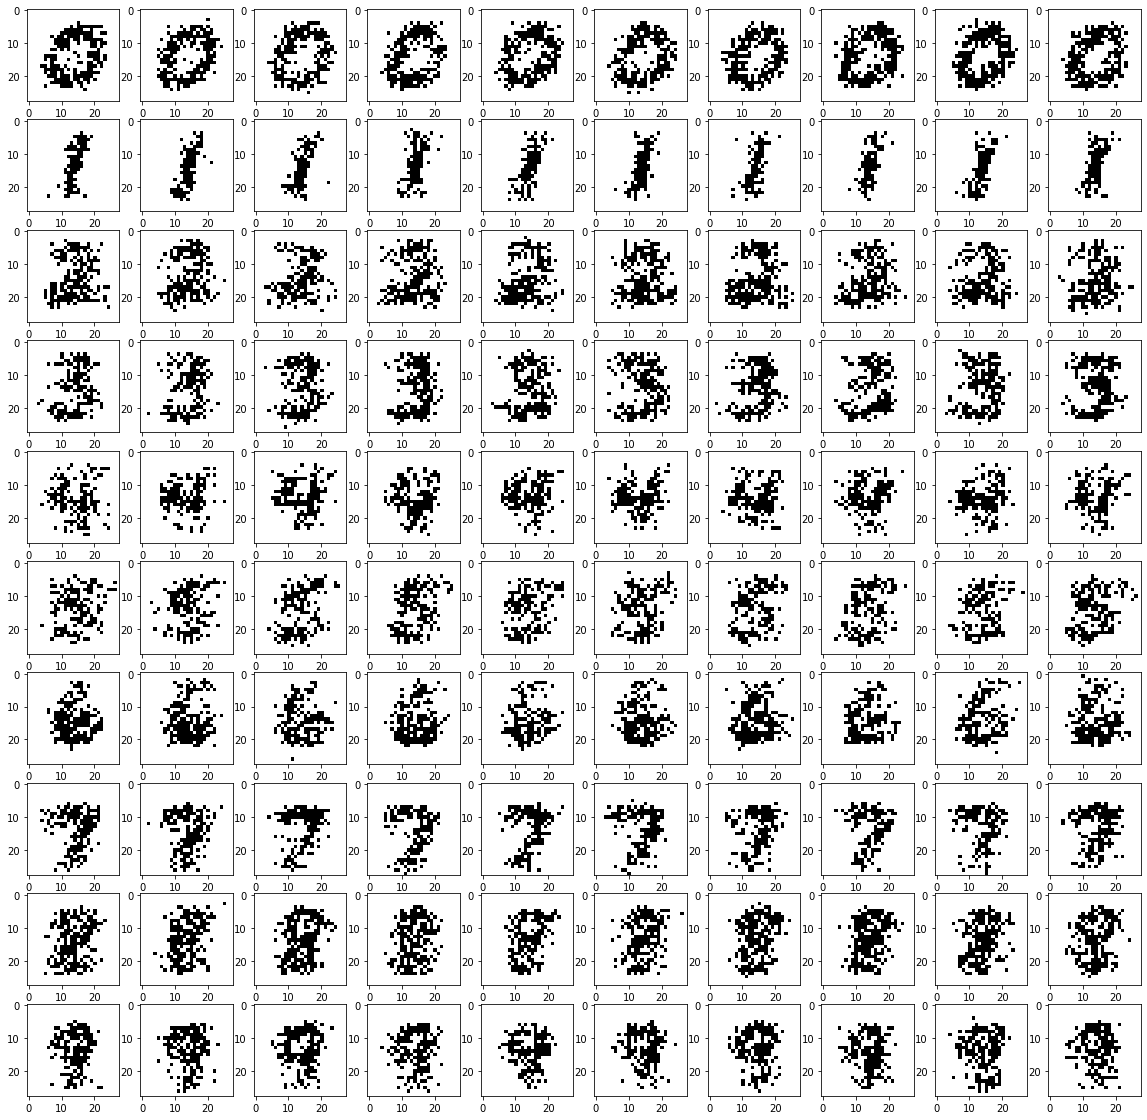

In [50]:
def Q5(num_examples):

### STUDENT START ###

    #train model
    NB = BernoulliNB(binarize=.1)
    NB.fit(train_data, train_labels)

    #create an empty list to store the generated images
    images = list()
    
    #for numbers 0 thru 9
    for i in range(10):
      #create the prob matrix for whatever number we're on
      prob_mat = np.exp(NB.feature_log_prob_[i])
      #to create 20 images
      for j in range(num_examples):
        #generate a sample matrix, zero it out, then fill it with random values
        samp = np.zeros(784)
        samp = np.random.rand(784)
        #compare those random values with our prob matrix to generate a boolen matrix
        #then multiply by 1 to fill in certain pixels, also reshape, then add to images  
        images.append(((prob_mat > samp)*1).reshape(28,28))

    #create a figure
    fig = plt.figure(figsize=(20,20))
    #print all the image arrays
    for m in range(len(images)):
      plt.subplot(10, 10, (m+1))
      plt.imshow(images[m], cmap=plt.cm.binary) 

### STUDENT END ###

Q5(10)

ANSWER: The images are not as crisp as those in the actual data set. The numbers with the worst resolution correspond to the numbers with the worst score in the confusion matrix from project 1.

### Question 6: Model Calibraiton
---
Recall that:
 * a **strongly calibrated** classifier is rougly 90% accurate when it says it is 90% accurate. The model's estimated posterior probability of the predicted class is indeed 0.9. 
 * A **weakly calibrated** classifier is more accurate when it "says" it is more accurate. The actual accuracy is higher when the model's estimated posterior probability is higher.
 * A **poorly calibrated** classifier has no positive correlation between the model's estimate posterior probability and the actual accuracy.

1. Produce a Bernoulli Naive Bayes model.  
1. Evaluate performance: 
  1. Partition the dev set into several buckets based on the estimated posterior probabilities of the predicted classes (predict_proba)
    - Think of it as a bin in a histogram, where each bin groups a range of estimated posterior probabilities of the predicted classes (predict_proba).
    - Then estimate the actual accuracy the classifier achieved for each bucket. 
    - So, for each prediction:
       - Find the bucket whose range includes the estimated posterior probability, 
       - and update "correct" and "total" counters accordingly. 
       - Show the accuracy for each bucket.
1. How would you characterize the calibration for this Bernoulli Naive Bayes model according to the definitions above?

Notes:
* Set LaPlace smoothing (alpha) to the optimal value (from part 8).
* Set binarization threshold to 0.
* Train on the mini train set.
* Evaluate perfromance on the dev set.



In [28]:
def Q6(buckets, correct, total):
    
### STUDENT START ###

    #train models
    NB = BernoulliNB(alpha = .001)
    NB.fit(mini_train_data, mini_train_labels)
    
    #generate accuracy at each 
    pred_prob = NB.predict_proba(dev_data)

    #place each entry into a bin based on max predicted probability in each row
    binned = np.digitize([np.max(i) for i in pred_prob], buckets, right = True)
    
    #use value in binned to increment total
    for i in binned:
        total[i] += 1
    
    #generate a prediction to compare to actual label.  
    pred = NB.predict(dev_data)
    
    #for loop to compare prediction and labels for correctness and then increment each bin 
    for i in range(len(binned)):
        #if pred matches actual label
        if pred[i] == dev_labels[i]:
            #add one to the right bin in correct
            correct[binned[i]] += 1
    
    #generate an accuracy list
    acc = np.array(correct)/np.array(total)
    for k in range(len(correct)):
        print("Bin: " + str(buckets[k]) +
             " Total: " + str(total[k])+ 
             " Correct: " + str(correct[k]))
        
    
    #show the correct and total bin numbers
    
    #print accuracies with corresponding bin 
    print("\nBin Accuracies (Bin - Accuracy): \n")
    print("0.5 - 0.0")
    for k in range(1,len(acc)):
        print(str(buckets[k]) + " - "+str(acc[k]))

### STUDENT END ###

buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]
correct = [0 for i in buckets]
total = [0 for i in buckets]

Q6(buckets, correct, total)

Bin: 0.5 Total: 0 Correct: 0
Bin: 0.9 Total: 31 Correct: 11
Bin: 0.999 Total: 67 Correct: 29
Bin: 0.99999 Total: 59 Correct: 27
Bin: 0.9999999 Total: 46 Correct: 30
Bin: 0.999999999 Total: 62 Correct: 48
Bin: 0.99999999999 Total: 33 Correct: 26
Bin: 0.9999999999999 Total: 43 Correct: 34
Bin: 1.0 Total: 659 Correct: 618

Bin Accuracies (Bin - Accuracy): 

0.5 - 0.0
0.9 - 0.3548387096774194
0.999 - 0.43283582089552236
0.99999 - 0.4576271186440678
0.9999999 - 0.6521739130434783
0.999999999 - 0.7741935483870968
0.99999999999 - 0.7878787878787878
0.9999999999999 - 0.7906976744186046
1.0 - 0.9377845220030349


/var/folders/q8/dr03k5ws7mj8d8hx7mjgmw3h0000gn/T/ipykernel_817/940512297.py:30: RuntimeWarning: invalid value encountered in true_divide
  acc = np.array(correct)/np.array(total)


ANSWER: The Bernouli Naive Bayes classifier is a weakly calibrated classifier.

### Question 7 EXTRA CREDIT: Feature generation
---
1. Design new features to see if you can produce a Bernoulli Naive Bayes model with better performance.
1. Show the accuracy of a model based on the original features and the accuracy of the model based on the new features.

**Note that improving results is actually hard.**

Here are a few ideas to get you started:
- Try summing or averaging the pixel values in each row.
- Try summing or averaging the pixel values in each column.
- Try summing or averaging the pixel values in each square block. (pick various block sizes)
- Try implementing [*maxpool*](https://computersciencewiki.org/index.php/Max-pooling_/_Pooling) features, taking a rolling maximum over sub-regions of a the image. 
- In any case, you can either transform the original data or add new "features" to it.

Notes:
* Train on the mini train set (enhanced to comprise the new features).
* Evaulate performance on the dev set.
* Ensure that your code is well commented.

In [ ]:
def Q7():

### STUDENT START ###

### STUDENT END ###

Q7()